# 국민건강보험 데이터

국민건강보험 데이터는 [국민건강보험 공공데이터 개방서비스](http://nhiss.nhis.or.kr/op/it/index.do)에서 제공되고 있다. 개인식별정보는 제외되었으며 표번은 매년 100만명의 무작위추출(Random Sampling)되었다. 자료는 매년 12월 2년 전 데이터를 추가하는 방식으로 직전년도 데이터는 추가되지 않는다. 여기서는 가장 최근 자료인 2015년도 데이터를 분석한다.

표본 추출방식은 코호트 연구(Cohort Study)로 진행되었다. Dataset은 다음과 같은 특징을 가진다.

* 다양한 Layer로 구성. (성별 2개층, 연령 18개층 등)
* 의료급여자 포함된 전국민 자료
* 건강검진 세부내역 열람가능
* 2002년부터 축적된 데이터
* 비급여항목의 부재

In [1]:
# Load Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# Settings
%matplotlib inline
sns.set(font="NanumGothic")
pbar = ProgressBar()
pbar.register()

### Data Loading

국민건강보험의 데이터는 진료내역정보(약 1,120만개), 의약품처방정보(약 3,000만개), 건강검진정보(100만개)로 방대한 데이터가 포함되어있다. 따라서 이를 다루기 위해서는 out-of-core computation이 필요하다. 따라서 여기서는 dask를 통해 데이터를 다루게 된다.

In [2]:
# Load Data
gj = dd.read_csv('./data/NHIS_OPEN_GJ_2015.CSV')  # Medical Examination Data
t20 = dd.read_csv('./data/NHIS_OPEN_T20_2015.CSV')  # Treatment Data
t60_part1 = dd.read_csv('./data/NHIS_OPEN_T60_2015_part1.CSV')
t60_part2 = dd.read_csv('./data/NHIS_OPEN_T60_2015_part2.CSV')
t60 = t60_part1.append(t60_part2)  # Prescription Data

국민건강보험에서 데이터는 세가지 형태로 제공된다.
1. 진료내역정보
2. 의약품처방정보
3. 건강검진정보

본 분석에서 진료내역정보는 `t20`, 의약품처방정보는 `t60`, 검진정보는 `gj`로 다루어진다.

# 데이터 정보

## 진료내역 정보

**1. 개념**

진료내역정보는 2002년부터 2015년까지의 국민건강보험 가입자 중 요양기관(병, 의원 등)으로부터의 진료이력이 있는 각 연도별 수진자 100만 명에 대한 기본정보(성, 연령대, 시도코드 등)와 진료내역(진료과목코드, 주상병 코드, 요양일수, 총처방일수 등)으로 구성된 데이터이다.

**2. 구성**

총 19개의 변수로 가입자 일련번호와 진료내역 일련번호, ① 수진자 기본정보 : 성, 연령,
거주지 시도코드와 같은 기본정보 ② 진료상세 정보 : 주상병, 부상병, 요양일수,
입·내원일수, 총 처방일수 등 구체적인 진료내역 정보, ③ 요양급여 청구 심사 결과 : 요양
급여비용 심사청구 결과 결정된 보험자와 수진자가 각각 부담해야 할 금액 등 요양급여
청구 심사결과 값에 대한 정보로 구성되어 있다.

**3. 항목설명**

|표준항목명|영문명|설명|
|---|---|---|
|기준년도|STND_Y|해당 정보의 기준년도를 제공함|
|가입자 일련번호|IDV_ID|가입자에 부여한 일련번호|
|진료내역 일련번호|KEY_SEQ|해당진료내역에 대한 일련번호|
|성별코드|SEX|해당 정보 대상자의 성별을 제공함|
|연령대 코드|AGE_GROUP|기준년도에 수진자 나이를 5세단위로 그룹화|
|시도코드|SIDO|해당 수진자 거주지의 시도코드|
|요양개시일자|RECU_FR_DT|해당 상병의 요양급여를 위해 수진자가 요양기관에 내원한 연, 월,일|
|서식코드|FORM_CD|명세서 서식구분을 위한 코드|
|진료과목코드|DSBJT_CD|의과 26종의 진료과목코드|
|주상병코드|MAIN_SICK|명세서 상의 주상병의 분류기호|
|부상병코드|SUB_SICK|상병분류기호 외의 추가상병의 분류기호|
|요양일수|VSCN|수진자가 요양급여를 받은 실 일수|
|입내원일수|RECN|수진자의 입원한 날부터 퇴원 일까지의 실 일수|
|심결가산율|EDEC_ADD_RT|요양개시일자 기준으로 종별 규모에 따라 시설, 인력, 장비 등의 투자비용을 고려하여 요양기관 종별에 따라 가산 적용되는 진료비의 가산율(%)|
|심결용양급여비용총액|EDEC_TRAMT|심결본임부담금과 심결보험자부담금 합친 금액|
|심결본인부담금|EDEC_SBRDN_AMT|수진자 본인이 부담해야 할 부담금|
|심결보험자부담금|EDEC_JBRDN_AMT|보험자가 부담하여야 하는 금액|
|총처방일수|TOT_PRES_DD_CNT|처방전을 발급한 경우 조제 투약하도록 처방한 일수의 합|
|데이터기준일자|DATA_STD_DT|데이터 작성 기준 일자|

**4. 질병분류기호**

|분류기호|분류명|
|---|---|---|
|A00-B99|특정 감염성 및 기생충성 질환|
|C00-D48|신생물|
|D50-D89|혈액및 조혈기관의 질환과 면역메커니즘을 침범하는 특정장애|
|E00-E90|내분비, 영양 및 대사 질환|
|F00-F99|정신 및 행동 장애|
|G00-G99|신경계통의 질환|
|H00-H59|눈 및 눈 부속기의 질환|
|H60-H95|귀 및 유돌의 질환|
|I00-I99|순환계통의 질환|
|J00-J99|호흡계통의 질환|
|K00-K93|소화계통의 질환|
|L00-L99|피부 및 피하조직의 질환|
|M00-M99|근골격계통 및 결합조직의 질환|
|N00-N99|비뇨생식계통의 질환|
|O00-O99|임신, 출산 및 산후기|
|P00-P96|출생전후기에 기원한 특정 병태|
|Q00-Q99|선천 기형, 변형 및 염색체이상|
|R00-R99|달리 분류되지 않은 증상, 징후와 임상및 검사의 이상소견|
|S00-T98|손상, 중독 및 외인에 의한 특정 기타 결과|
|U00-U99|특수목적 코드|
|V01-Y98|질병이환 및 사망의 외인|
|Z00-Z99|건강상태 및 보건서비스 접촉에 영향을 주는 요인|

## 의약품 처방정보

**1. 개념**

의약품처방정보는 2002년부터 2015년까지의 국민건강보험 가입자 중 의약품처방이력이 있는
각 연도별 수진자 100만 명에 대한 기본정보(성, 연령대, 시도코드 등)와 의약품처방전별 개별
의약품에 대한 처방내역(요양개시일자, 1회투약량, 1일투약량, 총투여일수 등)으로 구성된
개방데이터이다.

**2. 구성**

총 15개의 변수로 가입자 일렬번호, 의약품처방내역 일렬번호와 ① 수진자 기본정보 :
가입자일련번호, 성, 연령, 거주지 시도코드와 같은 기본정보 ② 의약품 처방 상세정보 :
처방전일련번호, 요양개시일자, 의약품 일반성분명코드, 1회·1일 투약량, 총 투여일수 단가,
금액 등 상세 의약품처방 내역에 대한 정보로 구성되어 있다.

**3. 항목설명**

|표준항목명|영문명|설명|
|---|---|---|
|기준년도|STND_Y|해당 정보의 기준년도를 제공함|
|가입자 일련번호|IDV_ID|가입자에 부여한 일련번호|
|처방내역 일련번호|KEY_SEQ|해당 처반전에 부여한 일련번호|
|일련번호|SEQ_NO|해당 약품 일련번호|
|성별코드|SEX|해당 정보 대상자의 성별을 제공함|
|연령대 코드|AGE_GROUP|기준년도에 수진자 나이를 5세단위로 그룹화|
|시도코드|SIDO|해당 수진자 거주지의 시도코드|
|요양개시일자|RECU_FR_DT|해당 상병의 요양급여를 위해 수진자가 요양기관에 내원한 연, 월,일|
|약품일반성분명코드|GNL_NM_CD|의약품의 주성분코드|
|1회투약량|DD_MQTY_FREQ|수진자에게 투여한 의약품의 1회 투약량|
|1일투약량|DD_EXEC_FREQ|수신자에게 1일 간 의약품을 투여한 횟수|
|총투여일수|MDCN_EXEC_FREQ|해당 의약품을 수진자에게 투여한 총 일수|
|단가|UN_COST|처방 내역상의 의약품 단가|
|금액|AMT|단가, 1회투약량, 1일 투약량, 총투여일수를 곱한 금액|
|데이터공개일자|DATA_SDT_DT|데이터 작성 기준 일자|

## 건강검진정보

**1. 개념**

건강검진정보란 2002년~2015년(14개년)동안 국민건강보험의 직장가입자와 40세 이상의
피부양자, 세대주인 지역가입자와 40세 이상의 지역가입자의 「일반검강검진」 결과와 이들
일반건강검진 대상자 중에 만40세와 만66세에 도달한 이들이 받게 되는「생애전환기건강진단」의
결과이다.

**2. 구성**

총 34개의 변수로 가입자 일렬번호와 ① 수진자 기본정보 : 성, 연령, 거주지 시도코드와
같은 기본정보 ② 건강검진결과 및 문진정보 : 신체, 몸무게, 허리둘레 등 신체사이즈 정보와
혈압, 혈당, 콜레스테롤, 요단백, 감마지피티와 같은 병리검사결과 시력과 청력, 구강검사와
같은 진단검사결과 그 외 음주와 흡연 여부에 대한 문진결과로 구성되어있다.

**3. 항목설명**

|표준항목명|영문명|설명|
|---|---|---|
|기준년도|HCHK_YEAR|해당 정보의 기준년도를 제공함|
|가입자 일련번호|IDV_ID|가입자에 부여한 일련번호|
|성별코드|SEX|해당 정보 대상자의 성별을 제공함|
|연령대 코드|AGE_GROUP|기준년도에 수진자 나이를 5세단위로 그룹화|
|시도코드|SIDO|해당 수진자 거주지의 시도코드|
|신장|HEIGHT|검진자의 키(5cm단위)|
|체중|WEIGHT|검진자의 몸무게(5kg)단위)|
|허리둘레|WAIST|검진자의 허리둘레|
|시력(좌)|SIGHT_LEFT|수검자의 좌측 눈의 시력|
|시력(우)|SIGHT_RIGHT|수검자의 우측 눈의 시력|
|청력(좌)|HEAR_LEFT|수검자의 좌측 귀의 청력|
|청력(우)|HEAR_RIGHT|수검자의 우측 귀의 청력|
|수축기혈압|BP_HIGH|검진자의 최고 혈압|
|이완기혈압|BP_LWST|검진자의 최저 혈압|
|식전혈당|BLDS|검진자 식사 전 혈당 수치|
|총 콜레스테롤|TOT_CHOLE|혈청 중의 에스텔형, 비에스테형 콜레스테롤의 합|
|트리글리세라이드|TRIGLYCERIDE|단순지질 혹은 중성지질|
|HDL콜레스테롤|HDL_CHOLE|HDL에 포함되는 콜레스테롤|
|LDL콜레스테롤|LDL_CHOLE|LDL에 함유된 콜레스테롤|
|혈색소|HMG|혈액이나 혈구 속에 존재하는 색소단백으로 글로빈과 엠으로 구성되며 혈중의 산소운반체로서의 역할 수행|
|요단백|OLIG_PROTE_CD|소변에 단백질이 섞여 나오는 것|
|혈청크레아티닌|CREATININE|크레아티닌은 크레이틴의 탈수물로 내인성 단백대사의 종말산물로서 신장에서 배설되고 그 증감은 음식물에 관계없이 근육의 발육과 운동에 관계함|
|혈청지오티AST|SGOT_AST|간 기능을 나타내는 혈액검사상으 ㅣ수치, 간세포 이외에 심장, 신장, 뇌, 근육 등에도 존재하는 효소로 이러한 세포들이 손상을 받는 경우 농도가 증가함|
|혈청지오티ALT|SGPT_ALT|간 기능을 나타내는 혈액검사상의 수치, ALT는 주로 간세포 안에 존재하는 효소로, 간세포가 손상을 받는 경우 농도가 증가함|
|감마지티피|GAMMA_GTP|간 기능을 나타내는 혈액검사상의 수치, 간 내의 쓸개관에 존재하는 효소로 글루타민산을 외부에 펩티드나 아미노산 등으로 옮기는 작용을 함. 쓸개즙 배설장애, 간세포 장애 발생 시 혈중에 증가하게 됨|
|흡연상태|SMK_STAT_TYPE_CD|해당 수검자의 흡연 상태 여부|
|음주여부|DRK_YN|해당 수검자의 음주 상태 여부|
|구강검진 수검여부|HCHK_OE_INSPEC_YN|해당 검진자가 구강검진을 선택하여 검진하였는지 여부에 대한 항목|
|치아우식증유무|CRS_YN|해당 수검자의 치아우식증 유무에 대한 항목|
|결손치유무|TTH_MSS_YN|해당 수검자의 결손치 존재 유무에 대한 항목|
|치아마모증유무|ODT_TRB_YN|해당 수검자의 치아마모증 유무에 대한 항목|
|제3대구치(사랑니)이상|WSDM_DIS_YN|해당 수검자의 제3대구치(사랑니)에 대한 이상 유무|
|치석|TTR_YN|해당 수검자의 치석 여부|
|데이터 공개일자|DATA_STD__DT|데이터 작성 기준일자|

# Adding Useful Features

## BMI (Body Mass Index)

BMI는 인간의 비만도를 나타내는 지수로 체중과 키의 관계로 다음과 같이 정의된다.

$$\text{BMI} = \frac{\text{WEIGHT(kg)}}{\text{HEIGHT(m)}^2}$$

비만의 기준은 나라별로 상이하나 대한비만학회에 따르면 국내에서는 하기와 같이 적용하고 있다.

|BMI|비만도|
|---|---|
|35이상|고도비만|
|30-35|중등도비만|
|25-30|경도비만|
|23-24.9|과체중|
|18.5-22.9|정상|
|18.5미만|저체중|

In [3]:
gj["BMI"] = gj.apply(lambda x: x.WEIGHT/((x.HEIGHT/100)**2), axis=1, meta=('x','f8'))
gj = gj.compute()

[########################################] | 100% Completed | 30.7s


In [4]:
gj.head(5)

,HCHK_YEAR,IDV_ID,SEX,AGE_GROUP,SIDO,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,...,SGOT_AST,SGOT_ALT,GAMMA_GTP,SMK_STAT_TYPE_CD,DRK_YN,HCHK_OE_INSPEC_YN,CRS_YN,TTR_YN,DATA_STD__DT,BMI
0,2015,1,2,15,45,155,60,88,0.6,0.7,...,17,28,23,1.0,1.0,0,NaN,NaN,20161220,24.973985
1,2015,2,2,15,11,155,65,98,1.2,0.6,...,25,30,41,1.0,1.0,1,NaN,0.0,20161220,27.055151
2,2015,3,2,11,26,155,65,85,1.2,0.9,...,18,16,25,1.0,0.0,0,NaN,NaN,20161220,27.055151
3,2015,4,1,9,41,175,75,89,0.2,0.2,...,28,40,50,1.0,1.0,1,0.0,NaN,20161220,24.489796
4,2015,5,1,16,47,160,50,78,0.5,0.6,...,20,13,19,2.0,0.0,1,NaN,0.0,20161220,19.531250


## 주상병, 부상병의 코드

주상병과 부상병은 알파벳과 질병의 숫자코드로 구성되어있다. 질병분류가 같을 경우 동일 알파벳을 사용하므로 분석의 용이성을 위해 주상병과 부상병 각각에 대해 코드로 구성된 별도의 Feature Column을 만든다.

In [5]:
t20["MAIN_SICK_CODE"] = t20.MAIN_SICK[t20.MAIN_SICK.notnull()].apply(lambda x: x[0], meta=('x', 'f8'))
t20["SUB_SICK_CODE"] = t20.SUB_SICK[t20.SUB_SICK.notnull()].apply(lambda x: x[0], meta=('x', 'f8'))
t20 = t20.compute()

[########################################] | 100% Completed | 14.4s


In [6]:
t20.head(5)

,STND_Y,IDV_ID,KEY_SEQ,SEX,AGE_GROUP,SIDO,RECU_FR_DT,FORM_CD,DSBJT_CD,MAIN_SICK,...,VSCN,RECN,EDEC_ADD_RT,EDEC_TRAMT,EDEC_SBRDN_AMT,EDEC_JBRDN_AMT,TOT_PRES_DD_CNT,DATA_STD_DT,MAIN_SICK_CODE,SUB_SICK_CODE
0,2015,970070,1,1,6,29,20151218,2,4,K358,...,5,9,0,1621240,315300,1305940,0,20161220,K,NaN
1,2015,372596,2,1,8,41,20151207,2,4,K358,...,6,13,0,2545350,542350,2003000,0,20161220,K,NaN
2,2015,363860,3,2,9,41,20151204,2,4,K358,...,4,11,0,2344790,451710,1893080,0,20161220,K,NaN
3,2015,192334,4,2,6,47,20151222,2,10,O342,...,7,14,0,2314100,486630,1827470,0,20161220,O,O
4,2015,960084,5,1,1,47,20151216,2,13,J353,...,4,9,0,1121030,127490,993540,0,20161220,J,H


# Exploratory Data Analysis

## 상위 10개 주상병, 상위 20개 부상병 추출

In [7]:
# Extracting TOP 10 Main Sick
main_sick_count = t20.MAIN_SICK.value_counts()
top10_main_sick = main_sick_count[:10]

# t20 table confined to top 10 main sick
t20_top10_sick = t20[t20.MAIN_SICK.isin(top10_main_sick.index)]

# Extracting Top 20 Sub Sick
main_sick_code_count = t20.MAIN_SICK_CODE.value_counts()
top10_main_sick_code = main_sick_code_count[:10]
t20_top10_sick_code = t20[t20.MAIN_SICK_CODE.isin(
        top10_main_sick_code.index)]

t20_top10_sick_with_sub_sick_code = t20_top10_sick_code.SUB_SICK_CODE.value_counts()
t20_top10_sick_with_sub_sick_code = t20_top10_sick_with_sub_sick_code[:20]
t20_main_sub_sick_code = t20_top10_sick_code[t20_top10_sick_code.SUB_SICK_CODE.isin(t20_top10_sick_with_sub_sick_code.index)]

## 상위 10개 주상병의 성별에 따른 countplot

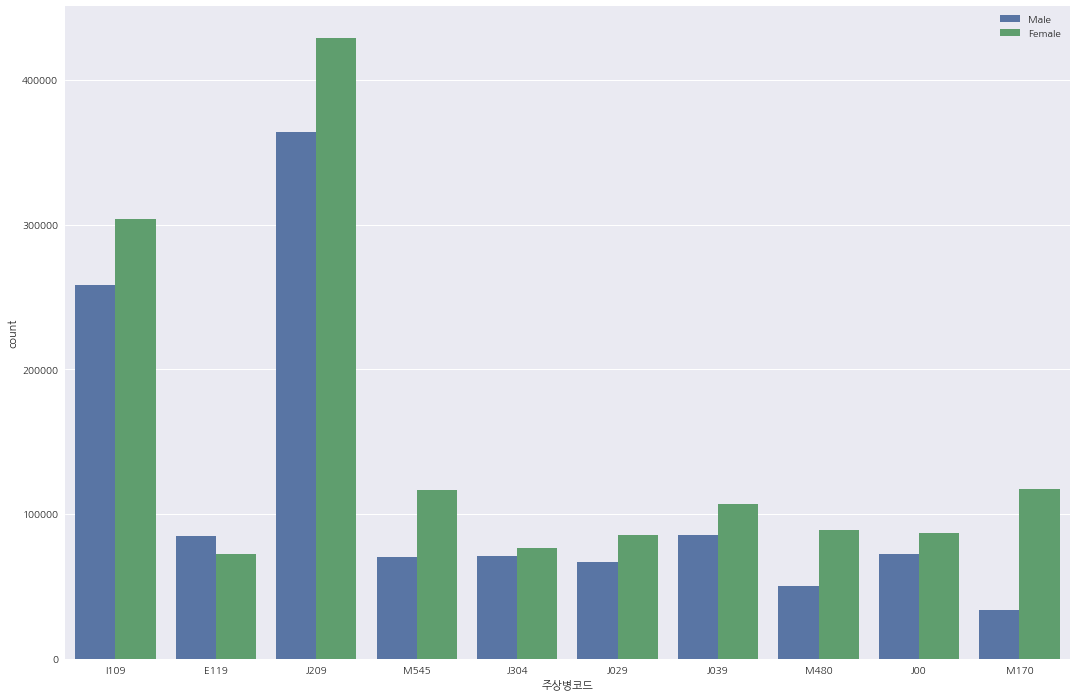

In [8]:
# MAIN_SICK, SEX / COUNT
plt.figure(figsize=(18,12))
sns.countplot(x="MAIN_SICK", hue="SEX", data=t20_top10_sick)
plt.legend(["Male", "Female"])
plt.xlabel("주상병코드")
plt.show()

가장 발생빈도가 높은 주상병 10개에 대해 살펴보자. 전반적으로 여성의 질병발생횟수가 남성보다 높은 것을 볼 수 있다. **M코드 질병의 경우 남성보다 여성에게서 발생하는 빈도가 상당히 높다는 것을 알 수 있다.** M코드 질병은 근골격계통 및 결합조직의 질환이며 그 중에서도 여성의 발생빈도가 가장 높은 M170은 무릎관절증이다. 이를 확인하기 위해 연령대별 주상병코드를 확인해보도록 하자. 전체적인 질병분포를 확인해보기위해 질병 대분류기호별로 살펴보자.

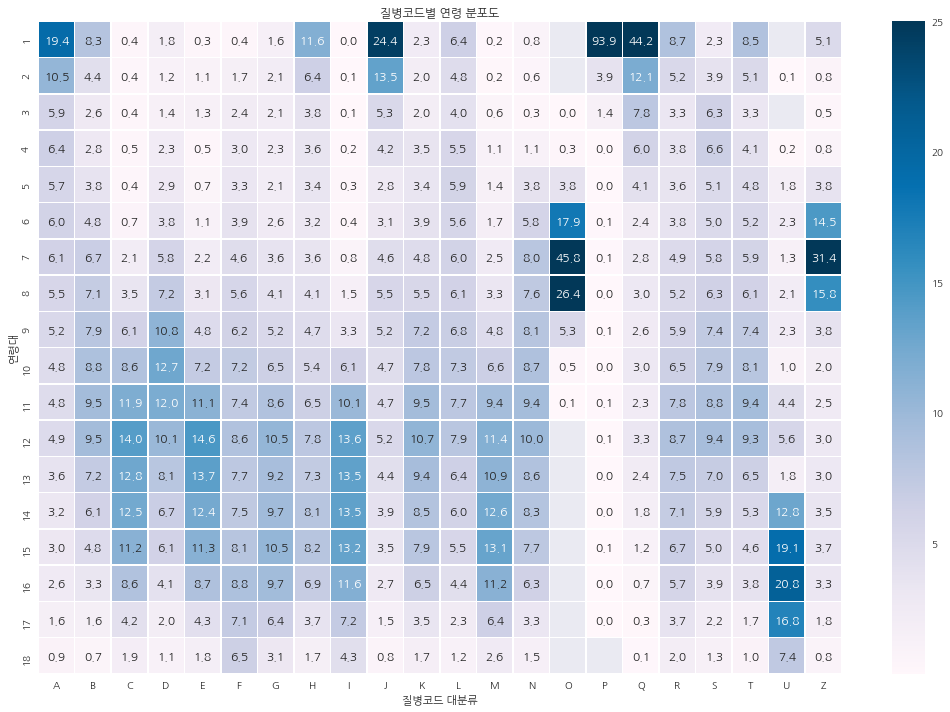

In [9]:
# 연령대와 질병코드별 테이블 생성
age_sick = t20.pivot_table(
        index="AGE_GROUP",
        columns="MAIN_SICK_CODE",
        aggfunc="size"
        )

# 질병마다 크기가 다르므로 비율로 변환
age_sick_r = age_sick.apply(lambda x: x/x.sum() * 100, axis = 0)

# 질병코드별 연령대 분포도 생성
plt.figure(figsize=(18, 12))
sns.heatmap(age_sick_r, annot=True, fmt=".1f", linewidths=.5, vmax= 25, cmap="PuBu")
plt.title("질병코드별 연령 분포도")
plt.xlabel("질병코드 대분류")
plt.ylabel("연령대")
plt.show()

위의 Heatmap은 질병코드를 연령대로 분류한 것이다. 진한 색깔일수록 발병률이 높다. 위의 Heatmap은 질병에 대한 많은 함의를 담고 있다. 몇 가지를 살펴보도록 하자.

* **여성발병률이 높았던 M170(무릎관절증)**

무릎관절증의 경우 연령분포상 40세부터 급격히 발병률이 증가하는 것을 알 수 있다. 앞의 표와 연계해 생각해 볼 경우 여성의 경우 이 나이대에 관절증을 예방하기 위한 조치를 취할 필요가 있음을 알 수 있다.

* **질병코드 J(호흡계통질환)**

0~10세가 약 40%를 차지한다, 즉 유아기에 호흡계통질환을 빈번한게 앓고 있음을 알 수 있다.

* **임신, 출산관련**

O(임신, 출산 및 산후기), P(출생전후기에 기원한 특정 병태), Q(선천 기형, 변형 및 염색체이상)의 경우 질병 특성상 출생기에 집중적으로 분포해 있다.

# 추가필요

## 지급보험금 분포

## 상위 10개 주상병에 대한 지급 보험금

상위 10개의 주상병의 지급보험금 규모를 확인하도록 하자.

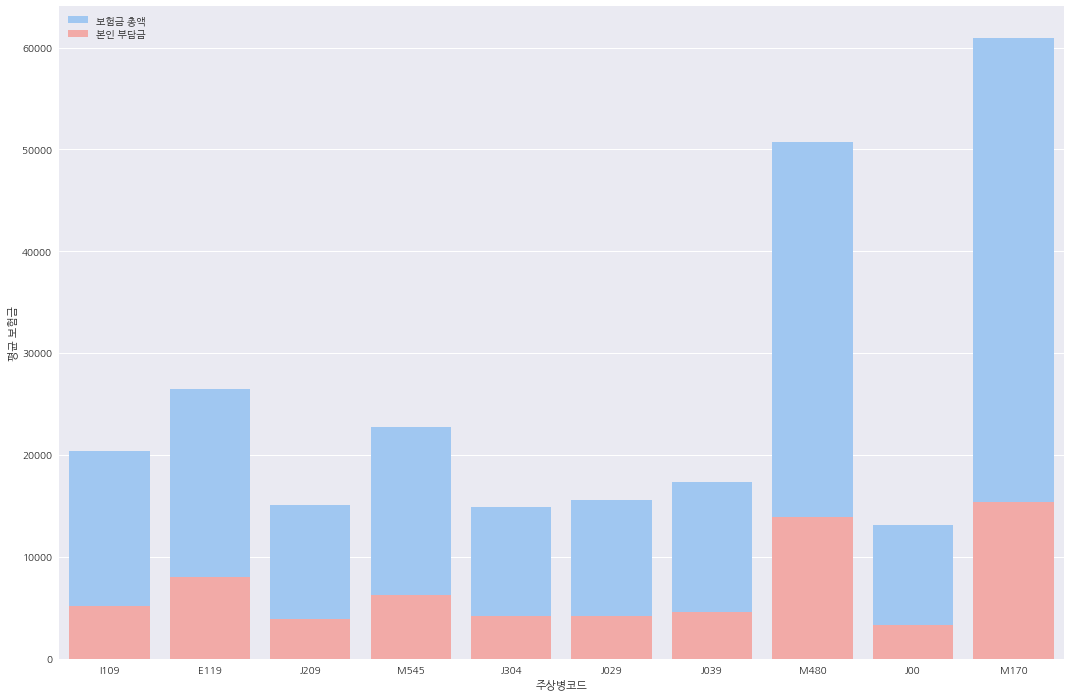

In [10]:
# MAIN_SICK / Insured CLAIM
plt.figure(figsize=(18,12))
sns.set_color_codes("pastel")
sns.barplot(x="MAIN_SICK", y="EDEC_TRAMT", data=t20_top10_sick,
            label="보험금 총액", color="b", ci=None)
sns.barplot(x="MAIN_SICK", y="EDEC_SBRDN_AMT", data=t20_top10_sick,
            label="본인 부담금", color="r", ci=None)
plt.legend()
plt.xlabel("주상병코드")
plt.ylabel("평균 보험금")
plt.show()

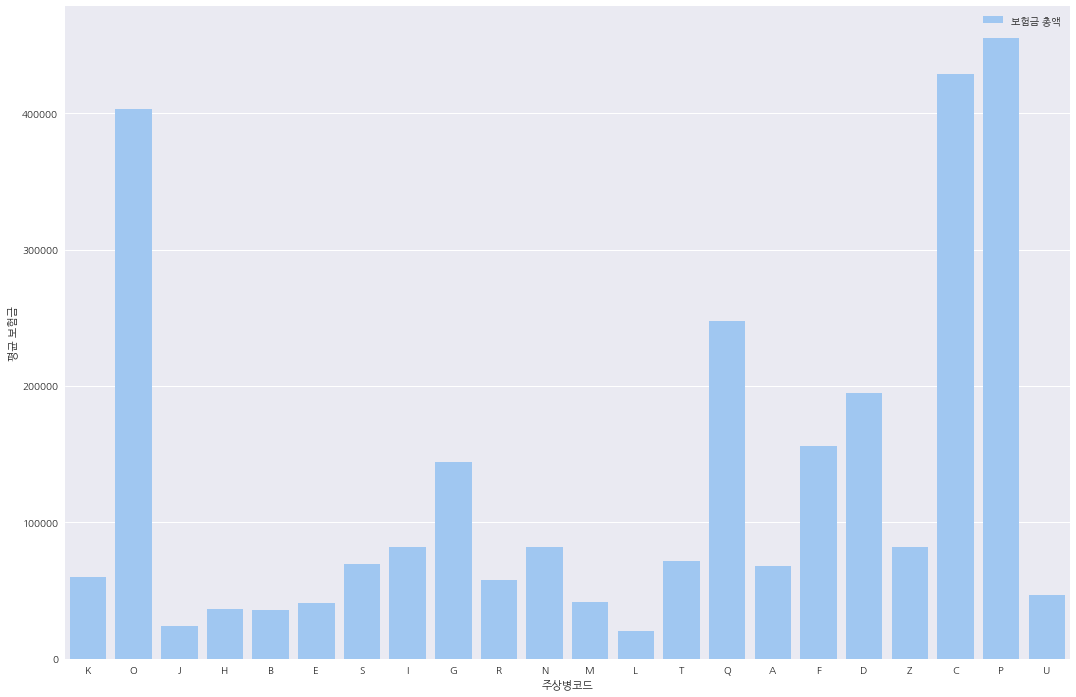

In [114]:
# MAIN_SICK / Insured CLAIM
plt.figure(figsize=(18,12))
sns.set_color_codes("pastel")
sns.barplot(x="MAIN_SICK_CODE", y="EDEC_TRAMT", data=t20,
            label="보험금 총액", color="b", ci=None)
plt.legend()
plt.xlabel("주상병코드")
plt.ylabel("평균 보험금")
plt.show()

In [115]:
t20.MAIN_SICK_CODE.value_counts()

J    2752839
M    2002030
I     917181
H     876042
S     726981
L     639253
K     627854
N     563765
E     474423
F     266419
B     254329
R     233559
G     171673
A     168169
C     164896
Z     156573
D     102043
T      80662
O      27976
Q      13571
P       9301
U       2391
Name: MAIN_SICK_CODE, dtype: int64

In [ ]:
t20.EDEC_TRAMT.

## 주상병과 부상병관의 상관관계

In [11]:
# MAIN_SICK, SUB_SICK / HEATMAP
t20_top10_sick_with_sub_sick = t20_top10_sick.SUB_SICK.value_counts()
t20_top10_sick_with_sub_sick = t20_top10_sick_with_sub_sick[:20]
t20_main_sub_sick = t20_top10_sick[t20_top10_sick.isin(t20_top10_sick_with_sub_sick.index)]

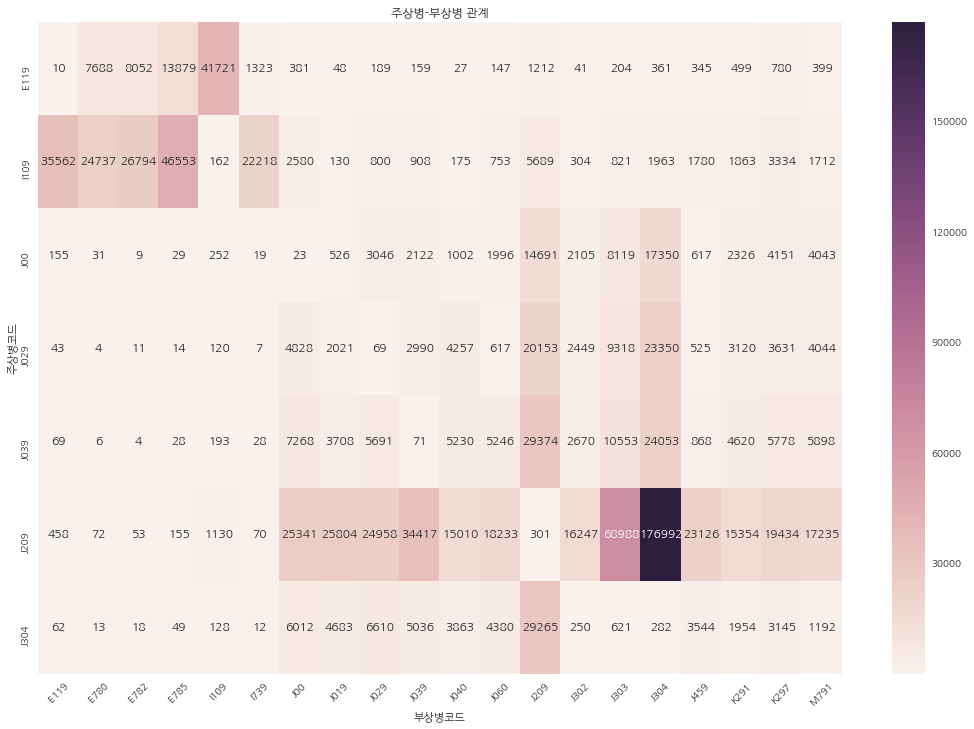

In [12]:
# HEATMAP
plt.figure(figsize=(18,12))
main_sub_sick_size = t20_main_sub_sick.pivot_table(index="MAIN_SICK",
                                                   columns="SUB_SICK",
                                                   aggfunc="size")
sns.heatmap(main_sub_sick_size, annot=True, fmt="d")
plt.xticks(rotation=45)
plt.title("주상병-부상병 관계")
plt.xlabel("부상병코드")
plt.ylabel("주상병코드")
plt.show()

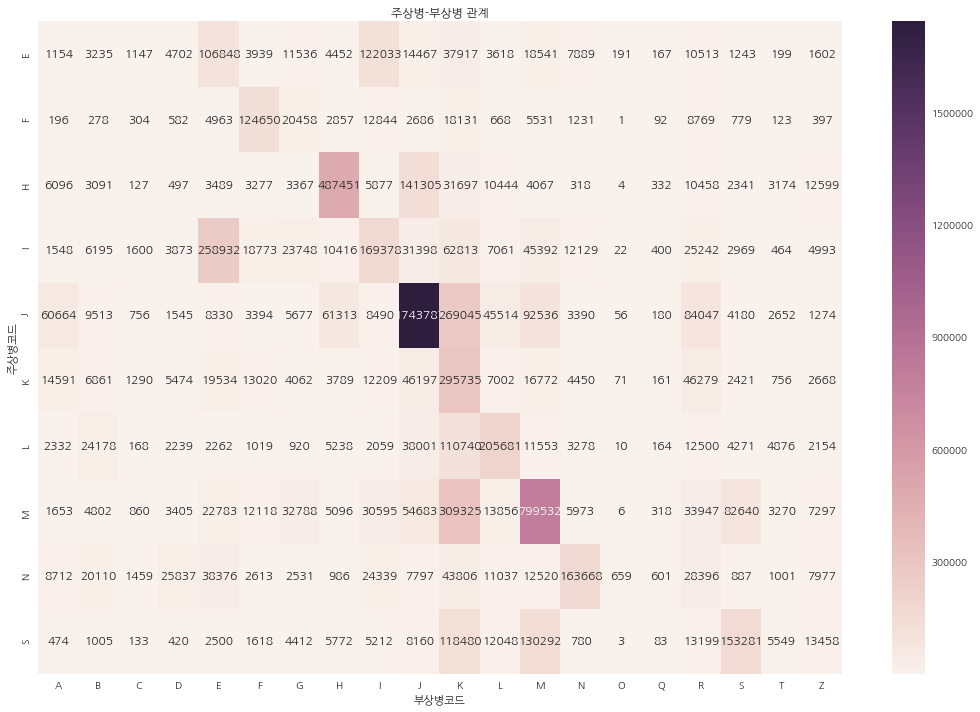

In [13]:
plt.figure(figsize=(18, 12))
main_sub_sick_size_code = t20_main_sub_sick_code.pivot_table(
        index="MAIN_SICK_CODE",
        columns="SUB_SICK_CODE",
        aggfunc="size"
        )
sns.heatmap(main_sub_sick_size_code, annot=True, fmt="d")
plt.title("주상병-부상병 관계")
plt.xlabel("부상병코드")
plt.ylabel("주상병코드")
plt.show()

# 흡연 음주 건강의 상관관계

In [14]:
gj.columns

Index(['HCHK_YEAR', 'IDV_ID', 'SEX', 'AGE_GROUP', 'SIDO', 'HEIGHT', 'WEIGHT',
       'WAIST', 'SIGHT_LEFT', 'SIGHT_RIGHT', 'HEAR_LEFT', 'HEAR_RIGHT',
       'BP_HIGH', 'BP_LWST', 'BLDS', 'TOT_CHOLE', 'TRIGLYCERIDE', 'HDL_CHOLE',
       'LDL_CHOLE', 'HMG', 'OLIG_PROTE_CD', 'CREATININE', 'SGOT_AST',
       'SGOT_ALT', 'GAMMA_GTP', 'SMK_STAT_TYPE_CD', 'DRK_YN',
       'HCHK_OE_INSPEC_YN', 'CRS_YN', 'TTR_YN', 'DATA_STD__DT', 'BMI'],
      dtype='object')

In [58]:
gj_sub = gj[["IDV_ID", "SEX", "AGE_GROUP", "BMI", "SMK_STAT_TYPE_CD", "DRK_YN"]]

In [59]:
t20_sub = t20[["IDV_ID", "MAIN_SICK", "MAIN_SICK_CODE","EDEC_TRAMT"]]

In [60]:
smoker_ID = gj[gj.SMK_STAT_TYPE_CD.isin([2,3])].IDV_ID
non_smoker_ID = gj[gj.SMK_STAT_TYPE_CD.isin([1])].IDV_ID
drink = gj[gj.DRK_YN.isin([1])].IDV_ID
no_drink = gj[gj.DRK_YN.isin([0])].IDV_ID

In [61]:
gj_t20_join = pd.merge(gj_sub, t20_sub, on="IDV_ID")
gj_t20_join

,IDV_ID,SEX,AGE_GROUP,BMI,SMK_STAT_TYPE_CD,DRK_YN,MAIN_SICK,MAIN_SICK_CODE,EDEC_TRAMT
0,1,2,15,24.973985,1.0,1.0,H101,H,54830
1,1,2,15,24.973985,1.0,1.0,Z944,Z,489980
2,1,2,15,24.973985,1.0,1.0,J209,J,17920
3,1,2,15,24.973985,1.0,1.0,Q442,Q,13880
4,1,2,15,24.973985,1.0,1.0,Z944,Z,791670
5,1,2,15,24.973985,1.0,1.0,Z944,Z,682630
6,1,2,15,24.973985,1.0,1.0,L308,L,17910
7,1,2,15,24.973985,1.0,1.0,Z944,Z,119090
8,1,2,15,24.973985,1.0,1.0,H521,H,28530
9,1,2,15,24.973985,1.0,1.0,Z944,Z,797230


In [105]:
smoke_drk = gj_t20_join.pivot_table(
        index="SMK_STAT_TYPE_CD",
        columns="DRK_YN",
        aggfunc="size"
        )

smoke_drk_r = smoke_drk.apply(lambda x: x/x.sum() * 100, axis=1)
smoke_drk_r

DRK_YN,0.0,1.0
SMK_STAT_TYPE_CD,,
1.0,34.370048,65.629952
2.0,69.868174,30.131826
3.0,76.286674,23.713326


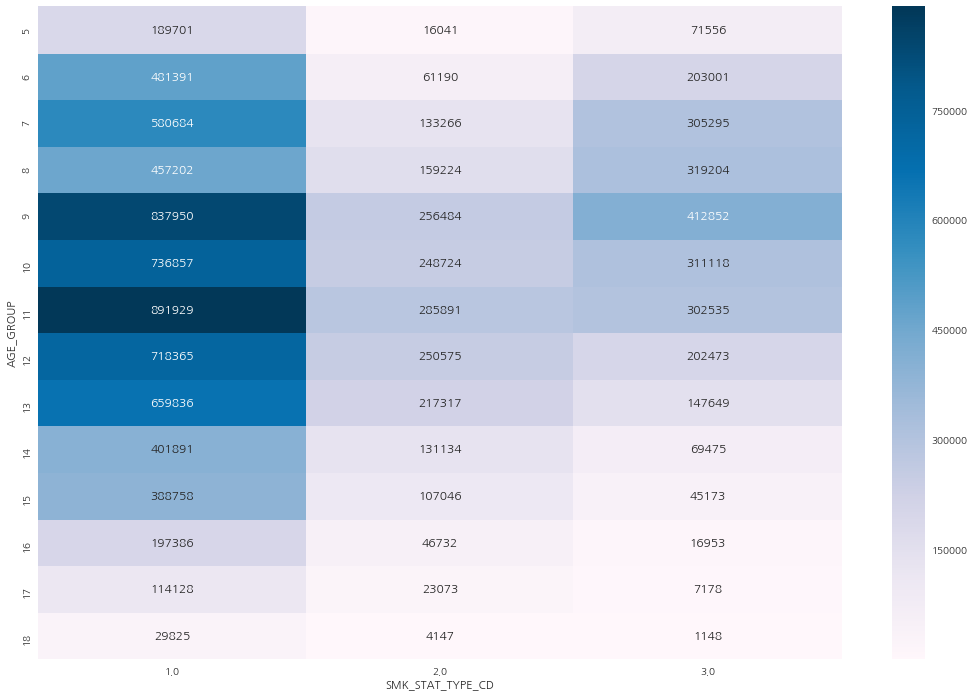

In [103]:
smoke_age = gj_t20_join.pivot_table(
        index="AGE_GROUP",
        columns="SMK_STAT_TYPE_CD",
        aggfunc="size"
        )

smoke_age_r = age_sick.apply(lambda x: x/x.sum() * 100, axis = 0)

plt.figure(figsize=(18, 12))
sns.heatmap(smoke_age_r, annot=True, fmt=".1f", linewidths=.5, vmax= 25, cmap="PuBu")
plt.show()